In [1]:
#setup
data_dir='../resource/asnlib/publicdata/Data'
#!ls $data_dir
state='NY'
m='SNWD'

## Spectral Analysis of Snow Depth in NY state

<img alt="" src="Figures/MeanStdSNWD_NY.png" style="width:800px" />


## Loading libdaries and data
### Load the required libraries

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.23.4 	required version>=0.19.2

     numpy as    np 	version=1.19.5 	required version>=1.12.0

   sklearn as    sk 	version=0.21.3 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.3.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.1.2 	required version>=6.0.0

version of ipwidgets= 7.1.2


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


### Read Statistics File

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


In [5]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

### Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|USC00303452|       SNWD|1917|[00 7E 00 7E 00 7...|
|USC00303452|       SNWD|1920|[00 7E 00 7E 00 7...|
|USC00303452|       SNWD|1921|[F0 57 60 56 60 5...|
|USC00303452|       SNWD|1928|[00 7E 00 7E 00 7...|
|USC00303452|       SNWD|1929|[00 7E 00 7E 00 7...|
+-----------+-----------+----+--------------------+
only showing top 5 rows



## Computing decomposition for each row, and add columns for coefficients and residuals

Residuals are the remainder left after successive approximations:  
1) Original vector = $\vec{v}$

2) $\vec{r}_0=\vec{v}-\vec{\mu}$

3) $\vec{r}_1=\vec{r}_0-(\vec{v}\cdot \vec{u}_1) \vec{u}_1$

4) $\vec{r}_2=\vec{r}_1-(\vec{v}\cdot \vec{u}_2) \vec{u}_2$

5) $\vec{r}_3=\vec{r}_0-(\vec{v}\cdot \vec{u}_3) \vec{u}_3$  
6) ......

For each reidual $\vec{r}_i$ we compute it's square norm, which we will refer to as **residual norm** :
$$\|\vec{r}_i\|_2^2 = \sum_{j=1}^n (r_{i,j})^2$$  
The smaller tha norm, the better the approximation.

#### A few things we know from linear algebra:

1) The zero'th residual norm is the square distance of $\vec{v}$ from the mean $\vec{\mu}$

2) The $k$'th residual norm is the minimal square between $\vec{v}$ and a point that can be exspressed as
$$ \vec{w}_k = \vec{\mu} + \sum_{i=1}^k c_i \vec{u}_i$$
Where $c_1,\ldots,c_k$ are arbitrary real numbers. We call $\vec{w}_k$ the $k$'th approximation or reconstruction of $\vec{v}$.

3) The residual norms are non-increasing.  
4) The residual vector $\vec{r}_n$ is the zero vector. In other words, $\vec{w}_n = \vec{v}$.

`decompose_dataframe` axtracts the series from the row, computes the `k` to decomposition coefficients and 
the square norm of the residuals and constructs a new row that is reassembled into a new dataframe.  

For more details, use `%load lib/decomposer.py`

In [7]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 2.4 s


In [8]:
%%time
print(df2.count())

14617
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.1 s


### Join decomposition information with station information

In [9]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')#.drop('Dist_coast').drop('Elevation').drop('Latitude').drop('Longitude').drop('Name')

In [10]:
stations_df.show(4)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 4 rows



In [11]:
jdf=df2.join(stations_df,on='Station',how='left')
jdf.show(1)

+-----------+-----------+--------------------+----+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+----------+--------+---------+---------+-----+--------------+
|    Station|Measurement|              Values|Year|            coeff_1|             coeff_2|            coeff_3|            coeff_4|             coeff_5|             res_1|             res_2|             res_3|             res_4|             res_5|           res_mean|total_var|Dist_coast|Latitude|Longitude|Elevation|State|          Name|
+-----------+-----------+--------------------+----+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+----------+--------+---------+---------+--

### Removing years with little snow
In some locations in NY and in some year, there is almost no snow accumulation. We want to treat these separately.

To do so we compare the error of using the average to the error of using a zero vector. We keep only those yearXstation where the mean is a better approximation than the zero Vector

In [12]:
%%time
#filter out vectors for which the mean is a worse approximation than zero.
print('all Rows',jdf.count())
df3=jdf.filter(jdf.res_mean<1)
print('Rows where mean is better approx than zero',df3.count())

all Rows 14617
Rows where mean is better approx than zero 8026
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.44 s


## Plot mean and top eigenvectors

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

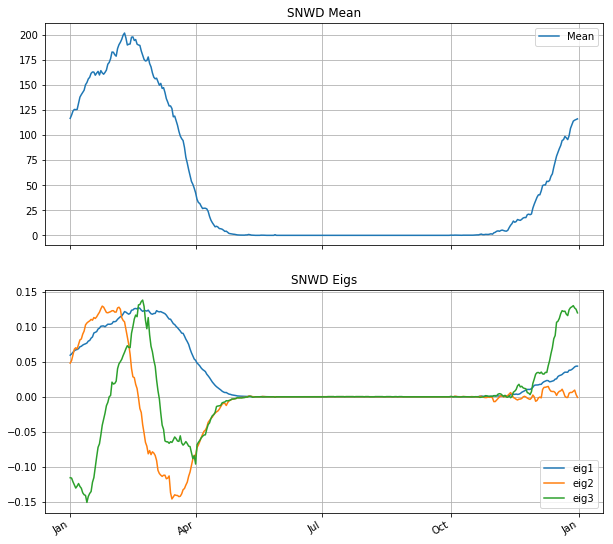

In [13]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('Outputs/SNWD_mean_eigs')

## plot Percentage of variance explained

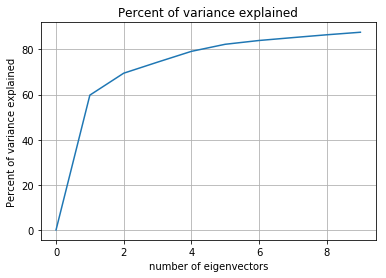

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Exploring the decomposition


### Intuitive analysis

In [15]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

(365, 3)


(365, 4)

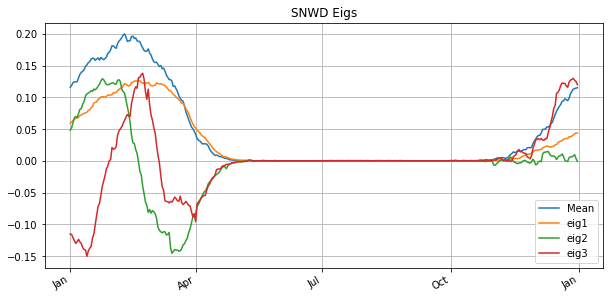

In [16]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 2

In [17]:
df4=df3.filter(df3.res_2<0.1).sort(df3.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

214


In [18]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|5732.151771...|-4492.96815...|-1378.43122...|0.431053050...|0.086598782...|0.058084529...|
|5991.271448...|-4262.68314...|410.6141061...|0.375265031...|0.097700990...|0.096251436...|
|11306.42042...|-3586.18852...|214.6349736...|0.143948071...|0.057825679...|0.057517182...|
|5177.435156...|-3226.95216...|300.9781904...|0.344233804...|0.093147264...|0.091152471...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



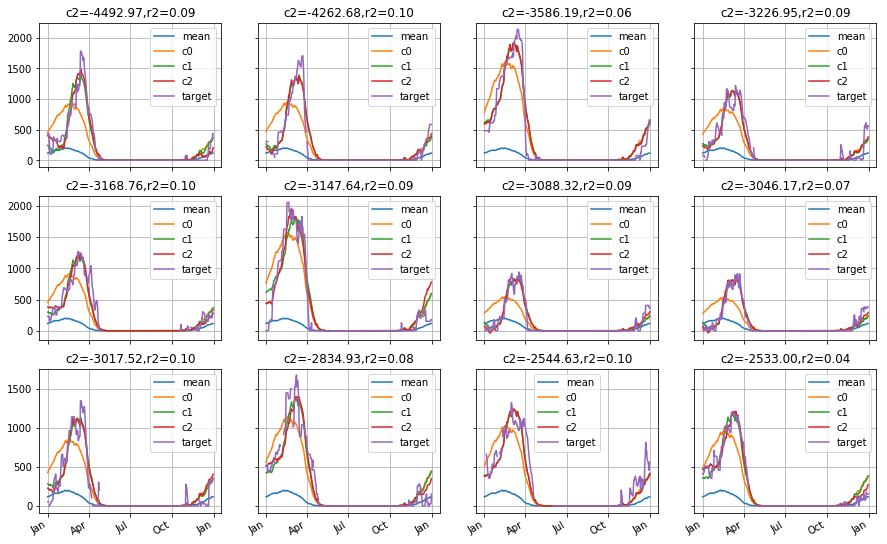

In [19]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('Outputs/SNWD_grid_negative_coeff_2.png')

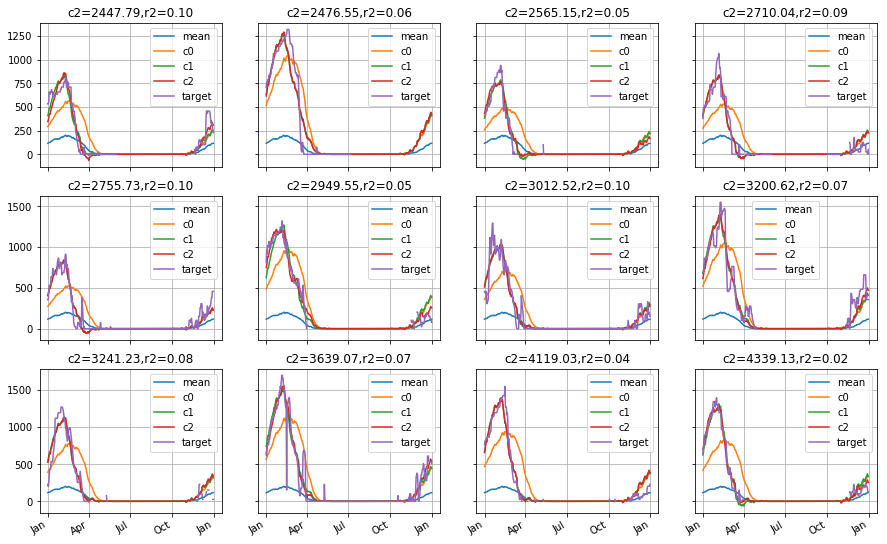

In [20]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)
savefig('Outputs/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 3

In [21]:
df4=df3.filter(df3.res_3<0.1).sort(df3.coeff_3)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

317


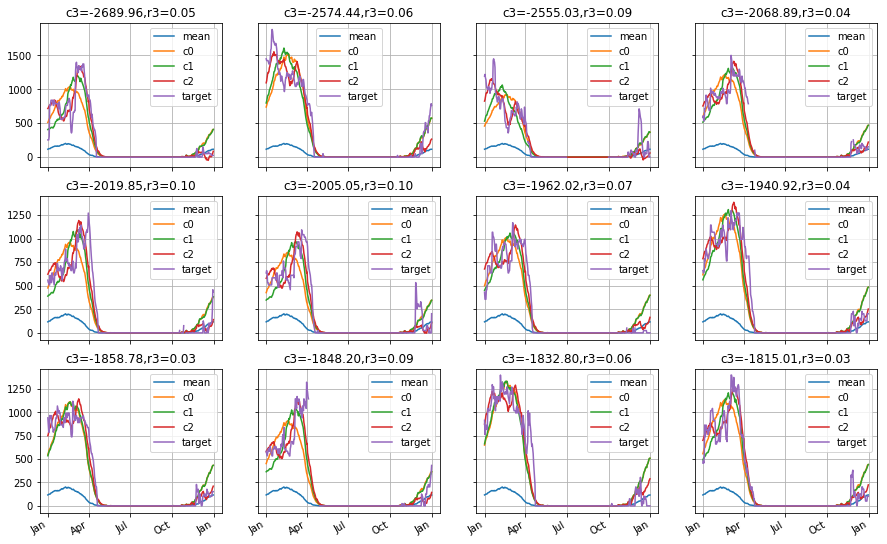

In [22]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c3=%3.2f,r3=%3.2f',params=('coeff_3', 'res_3'))
savefig('Outputs/SNWD_grid_negative_coeff_3.png')

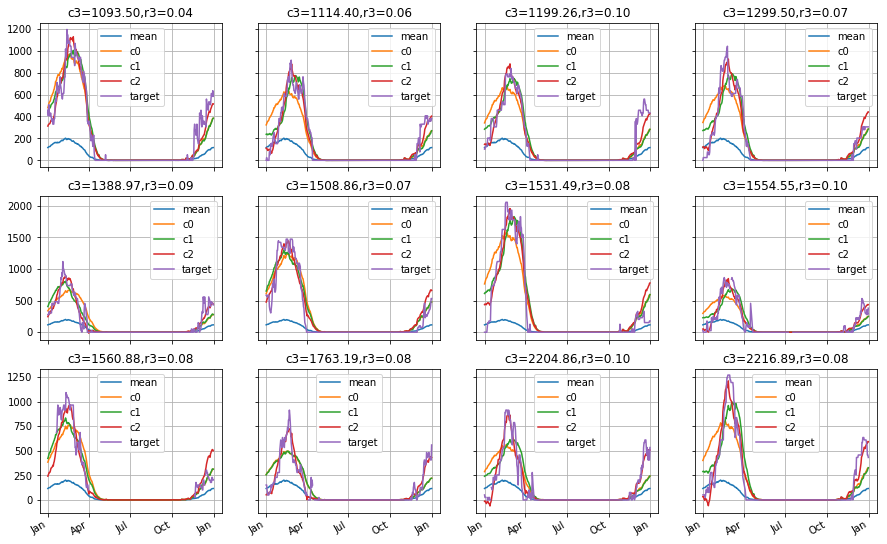

In [23]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c3=%3.2f,r3=%3.2f',params=('coeff_3', 'res_3'))

## Goodness of fit

In [24]:
df4=df3.sort(df3.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

8026
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|5053.259734...|4339.126273...|-664.278730...|0.014758952...|
|6204.511279...|2949.545596...|-1078.33431...|0.018695274...|
|6602.882866...|-1751.90793...|-504.378498...|0.019963722...|
|6095.539731...|-2533.00094...|-944.970478...|0.023466962...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



### Best Fit

First, lets plot the SNWD sequences which are best approximated using the first three eigen-vectors.

In other words, the sequences for which the third residual is smallest.

We can think of these as **architypical** sequences.

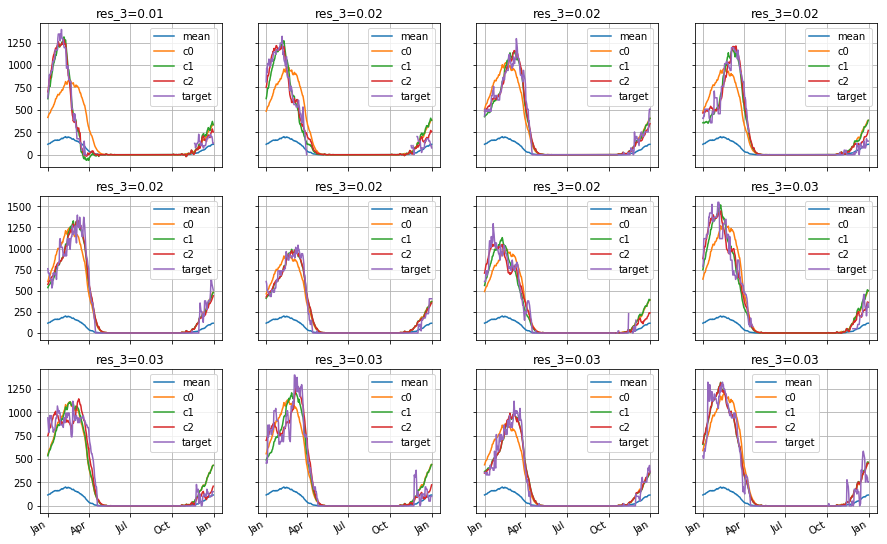

In [25]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## worst fit

Next, lets look at the sequence whose third residual is largest.

We can think of those as **outliers** or **noise**. These seuqnces do not fit our model. 

Have many of these outliers is a problem: we are either getting poor data, or else our model is inadequate.

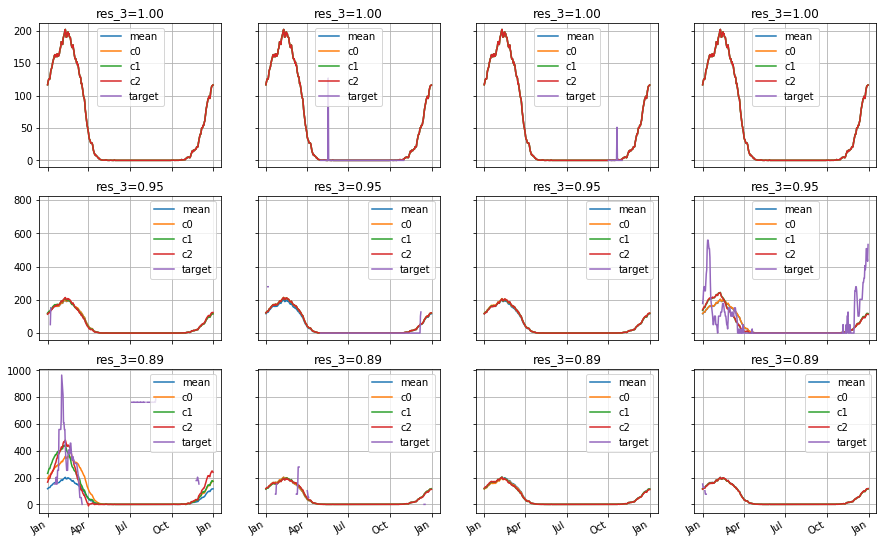

In [26]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

### Something to try
Clearly, the majority of the poor fits are a result of undefined entries in the data.  
Can you change the command to focus on years where most of the measurements are defined?

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [27]:
row=all_rows[73]
target=np.array(unpackArray(row.Values,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.7836729326834759
residual normalized norm  after mean + top eigs: [0.12130639 0.10912292 0.05603343]


VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=10473.644394940535, orientation='vertical', step=1047.3644394940534), FloatSlider(value=0.0, description='c1', max=1233.288227980465, orientation='vertical', step=123.3288227980465), FloatSlider(value=0.0, description='c2', max=0.0, min=-2574.443504006562, orientation='vertical', step=257.44435040065616))), Output()))

### Try other measurements/years/station

Have fun playing with the reconstruction of other signals

## Saving the decompositions

We save the decompositions dataframe `df3` in a parquet file for later use.

In [28]:
filename='Outputs/recon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

## Studying the distribution of the coefficients.

The top 5 coefficients are a **low dimensional representation of the 365 day sequence**.

We extract into a pandas dataframe the top 3 coefficients together with some other variables and then use pandas extensive visualization methods to gain insight to the data.

In [29]:
pdf=df3.select(['Station','Year','coeff_1','coeff_2','coeff_3','res_1','res_2','res_3','res_mean','total_var']).toPandas()

In [30]:
pdf.columns

Index(['Station', 'Year', 'coeff_1', 'coeff_2', 'coeff_3', 'res_1', 'res_2',
       'res_3', 'res_mean', 'total_var'],
      dtype='object')

### Scatter-plots

We believe that high values of `coeff_3` correpond to a short snow season.

We use a scatter-plot to look at the relationship between the year and the values of coeff_3 for the different stations in NY.

We limit ourselves to the yeras after 1950 where we have more data.

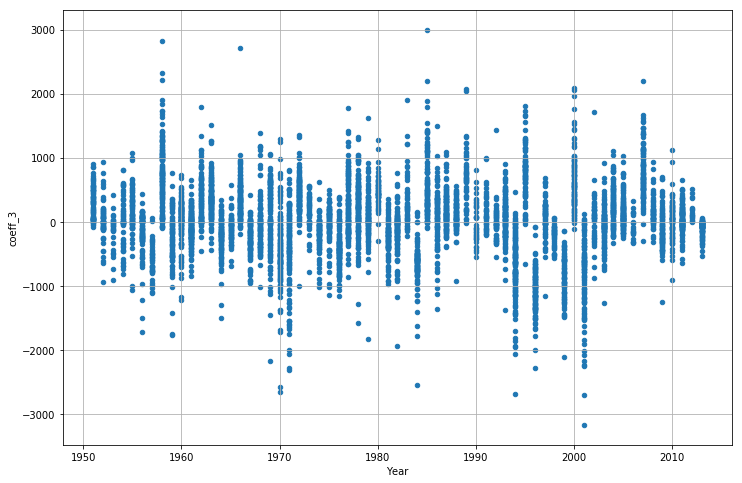

In [31]:
pdf[pdf['Year']>1950].plot.scatter('Year', 'coeff_3', figsize=[12,8]);
grid()

### Visualizing using box-plots

The scatter plot above demonstrates a commmon problem when visualizing large data.

- A lot of points.
- High overlap between points creats saturated regions where estimating density is hard

[Box-plots](https://en.wikipedia.org/wiki/Box_plot) are a good way to overcome this problem by displaying statistcs of the point distribution, rather than the points themselves.

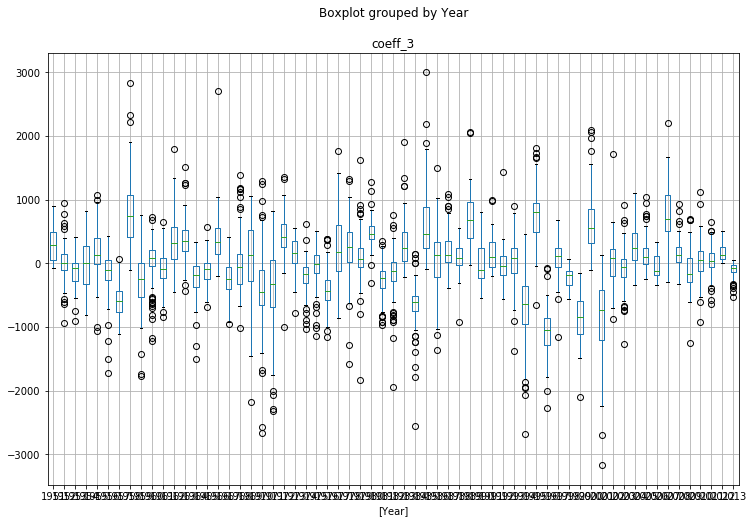

In [32]:
pdf[['Year','coeff_3']][pdf['Year']>1950].boxplot(by='Year',figsize=[12,8])

## Relations between the coefficients.

`coeff_1` represents high snow-fall, which `coeff_2` defines whether the snow season is early or late. The absolute magnitude of `coeff_2` is controlled by `coeff_1` (when there is little snow, a small coefficient of `coeff_2` suffices to change the time of the snow.

This is reflected in the scatter plot below.

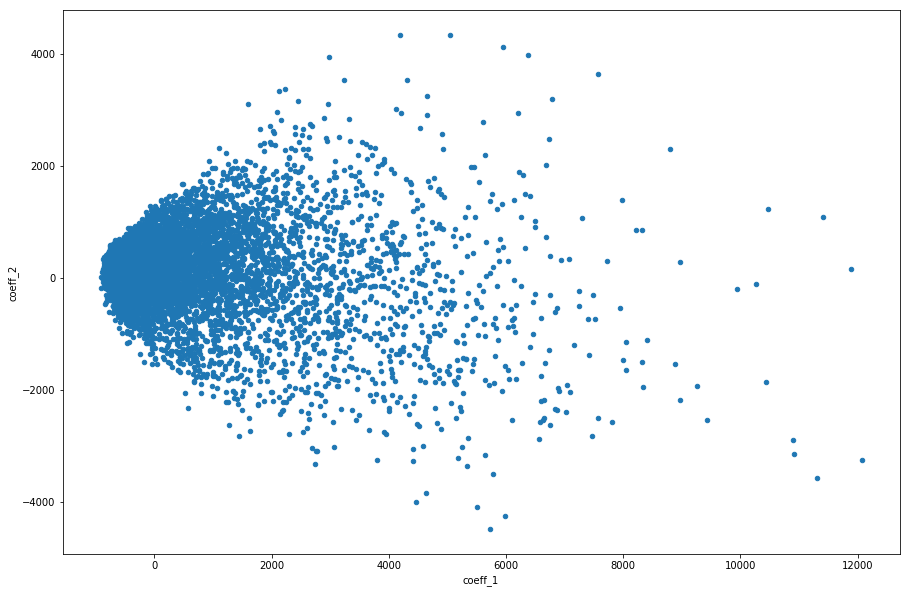

In [33]:
pdf.plot.scatter('coeff_1','coeff_2',figsize=[15,10])

### How does the residual decrease as the number of coefficients increase?

In [34]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df4.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    axis.plot(vals,P,label=feat)

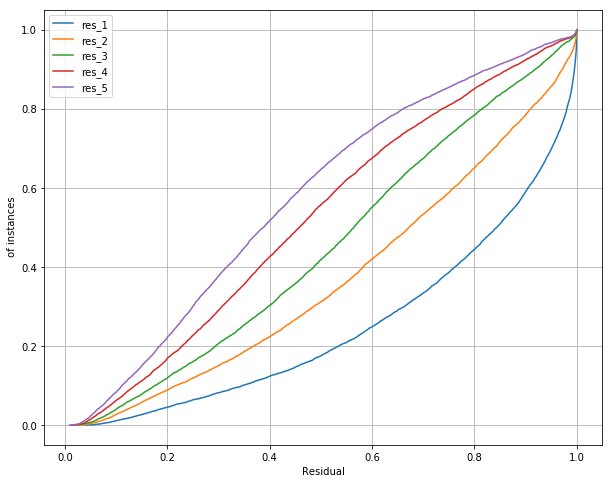

In [35]:
figure(figsize=(10,8))
axis=gca()

#plot_CDF('res_mean') # why does this not fit?
plot_CDF('res_1')
plot_CDF('res_2')
plot_CDF('res_3')
plot_CDF('res_4')
plot_CDF('res_5')
ylabel(' of instances')
xlabel('Residual')
grid()
legend()

# Summary

- When a small number of the top eigen-vectors explain most of the variance, we have a low dimensional representation.
- This is quantified by "Percent of variance explained" graphs.
- The low dimensional representation is useful because:
    1. It identifies the importnat degrees of freedom of the mechanism generating our data.
    1. It allows us to construct a good estimate of the raw data.
    1. Representing a long (365) sequence using only 3 variables allows us to relate the sequence to other quantities and identify statistically significant trends. 